In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import anndata as ad
import squidpy as sq
import scanpy as sc
import scvi

import os

from matplotlib import pyplot as plt

In [3]:
#FILEPATHBASE = '/Users/mmd47/Library/CloudStorage/GoogleDrive-mmd47@yale.edu/My Drive/DiStasio Lab/DiStasio Lab Share/'
FILEPATHBASE = '/home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/'

# --------------------------------------------------------------------------------
SAVEFIGS = True
if SAVEFIGS:
    IMGDIR = os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'img')



# --------------------------------------------------------------------------------
# Load concatenated datasets (generated by Preprocess.py
# --------------------------------------------------------------------------------
filename = os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'calc', 'retinas_all.h5ad')
retinas_all = ad.read_h5ad(filename)

In [4]:
retinas_all.layers['counts']

<31378x34658 sparse matrix of type '<class 'numpy.float32'>'
	with 2523398 stored elements in Compressed Sparse Row format>

In [21]:
retinas_all.obs['batch'] = retinas_all.obs['dataset']
retinas_all.obs['batch'][retinas_all.obs['batch'] == 'R2'] = 'R1'

retinas_all.raw = retinas_all  # keep full dimension safe
sc.pp.highly_variable_genes(
    retinas_all,
    flavor="seurat_v3",
    n_top_genes=6000,
    layer="counts",
    batch_key='batch',
    subset=True,
    span=1
)


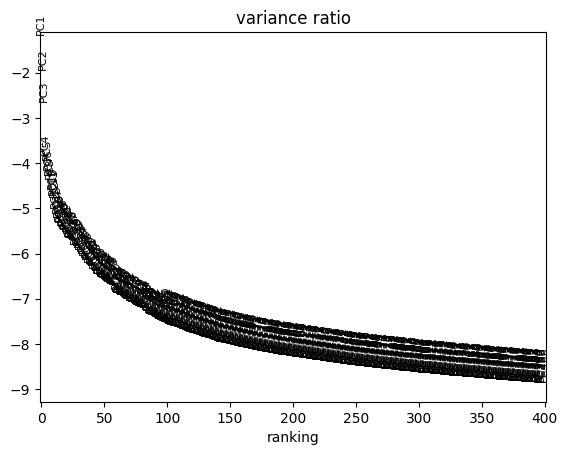

In [28]:
sc.tl.pca(retinas_all, svd_solver='arpack', n_comps=400)
sc.pl.pca_variance_ratio(retinas_all, log=True, n_pcs=400)


Global seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Batch Correction with scvi-tools...
Last run with scvi-tools version: 1.0.4
Epoch 255/255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [06:18<00:00,  1.45s/it, v_num=1, train_loss_step=93.2, train_loss_epoch=90.5]

`Trainer.fit` stopped: `max_epochs=255` reached.


Epoch 255/255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [06:18<00:00,  1.48s/it, v_num=1, train_loss_step=93.2, train_loss_epoch=90.5]


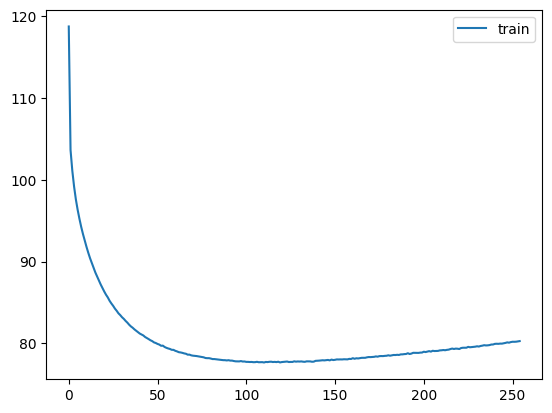

In [22]:
print('Batch Correction with scvi-tools...')



scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)


scvi.model.SCVI.setup_anndata(
    retinas_all,
    layer="counts",
    batch_key="batch"
)

model = scvi.model.SCVI(retinas_all,
                        n_layers=2, 
                        n_latent=30, 
                        gene_likelihood="nb")
model.train()

plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
plt.legend()

Nov 08 01:57:44 AM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Nov 08 01:57:44 AM: The following items have duplicates [  206   349   573   634   725   943  1011  1312  1812  2000  2084  2300
  2302  2807  2813  2816  2875  3562  3938  4222  4238  4391  4409  4483
  4554  4624  4652  4707  5209  5275  5357  5384  5553  5624  5640  5782
  5887  5906  6032  6107  6538  6682  6861  7007  7108  7256  7474  7477
  7677  7777  7936  8067  8118  8171  8195  8229  8274  8743  8840  8895
  8962  8965  9040  9397  9654  9870 10602 12771 12863 12867 13145 15073
 15343 17374 17856 18186 19984 20736 20832 21098 22102 22476 22976 23085
 23310 23555 23712 23721 23846 24184 24382 24844 25109 25323 25377 25562
 25569 25605 25708 25721 25724 25882 25938 26019 26033 26041 26067 26122
 26229 26425 26771 26869 27203 27427 27471 27641 27739 27755 27772 27784
 27846 27882 27931 28149 28169 28466 28514 28553 28621 28778 28789 28796
 28853 2

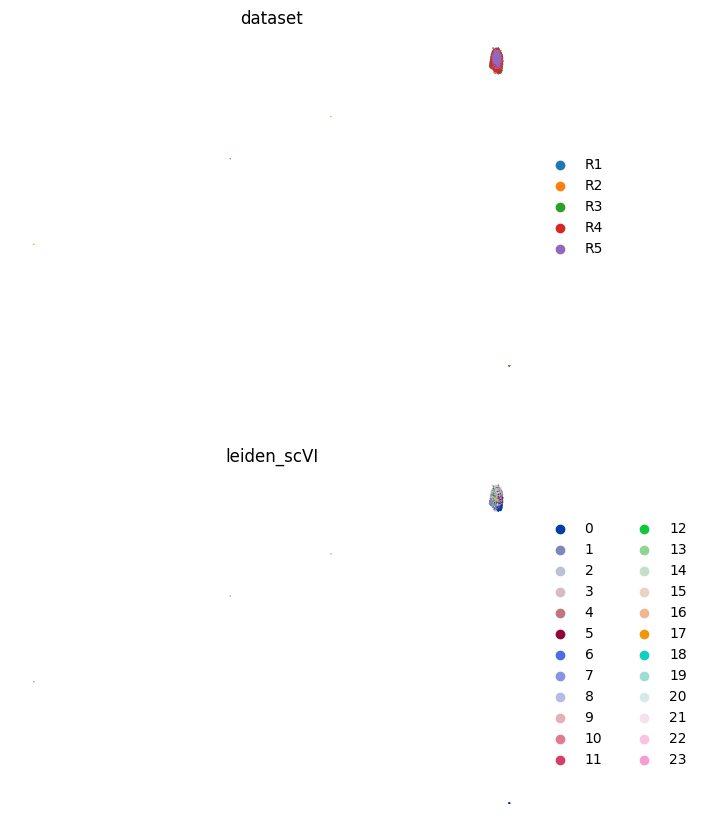

In [23]:
# use scVI latent space for MDE

SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
retinas_all.obsm[SCVI_LATENT_KEY] = latent

SCVI_NORMALIZED_KEY = "scvi_normalized"
retinas_all.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

sc.pp.neighbors(retinas_all, use_rep=SCVI_LATENT_KEY)

SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(retinas_all, key_added=SCVI_CLUSTERS_KEY)

SCVI_MDE_KEY = "X_scVI_MDE"
retinas_all.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(retinas_all.obsm[SCVI_LATENT_KEY])

sc.pl.embedding(
    retinas_all,
    basis=SCVI_MDE_KEY,
    color=["dataset", "leiden_scVI"],
    frameon=False,
    ncols=1,
)

#out_filename = os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'calc', 'retinas_all_scvi.h5ad')
#retinas_all.write(out_filename)

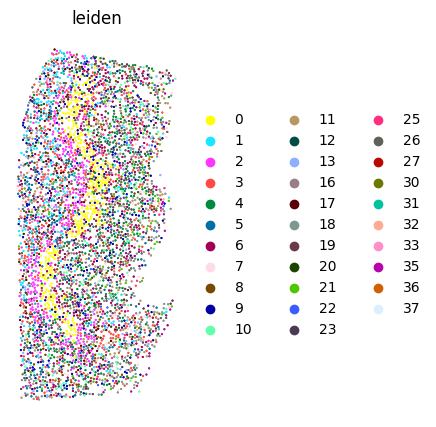

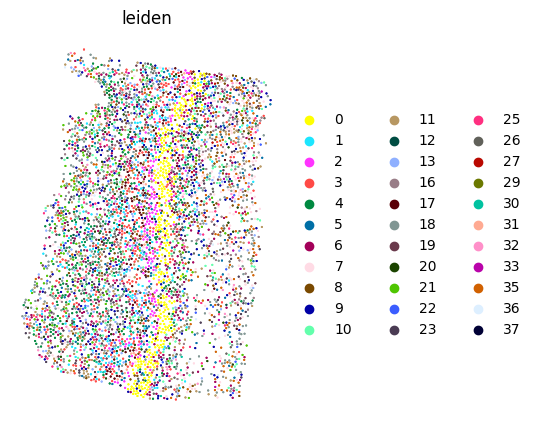

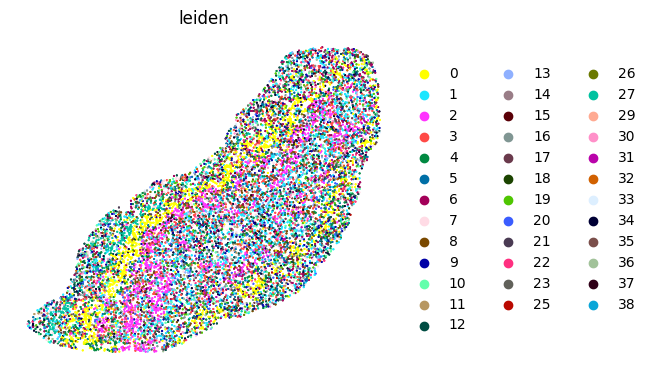

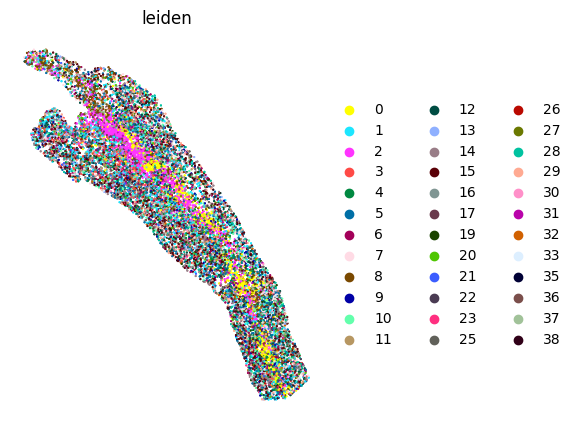

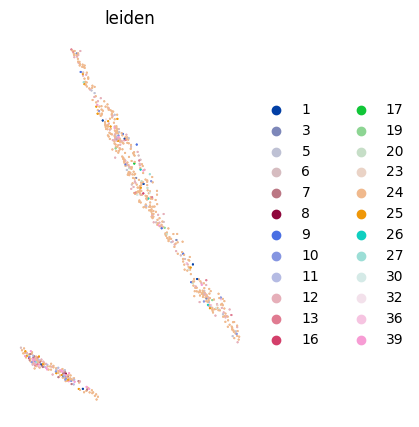

In [24]:
SAVEFIGS = False

fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R1'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_1.png'), dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R2'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_2.png'), dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R3'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_3.png'), dpi=300)
    
fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R4'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_4.png'), dpi=300)    
    
fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R5'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_5.png'), dpi=300)    

In [10]:
### END of SCVI stuff

In [21]:
sc.pp.log1p(retinas_all)

## Clustering
print('Clustering...')
sc.tl.pca(retinas_all, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(retinas_all, n_neighbors=20, n_pcs=30)
sc.tl.leiden(retinas_all)
sc.tl.paga(retinas_all)
sc.pl.paga(retinas_all, plot=False)
sc.tl.umap(retinas_all, init_pos='paga')

print('Done!')

Clustering...
Done!


/home/mdistasio/miniconda3/envs/scvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mdistasio/miniconda3/envs/scvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mdistasio/miniconda3/envs/scvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

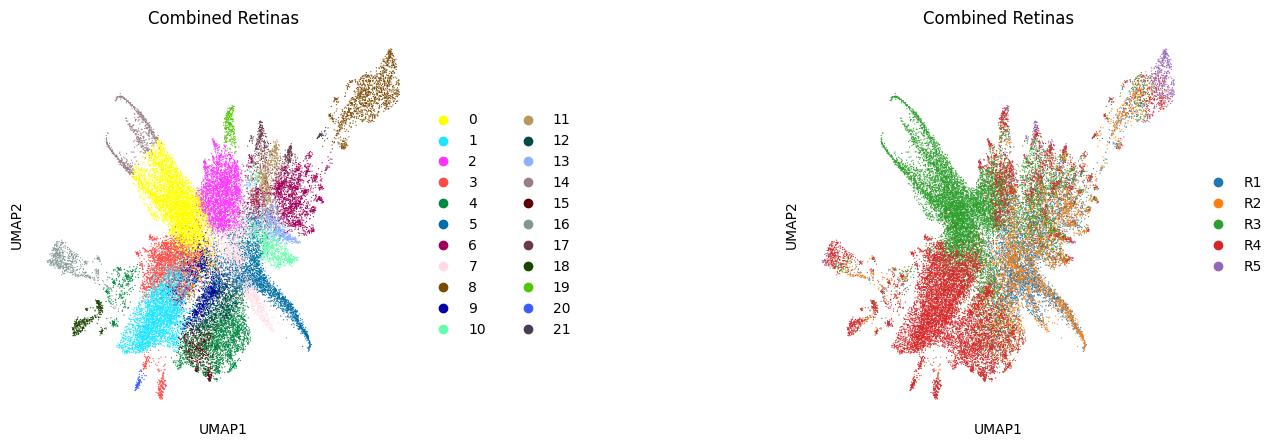

In [22]:
fig, axx = plt.subplots(1, 2, figsize=(15,5),  gridspec_kw={'wspace': 1})
sc.pl.umap(retinas_all, color="leiden", size=3, ax=axx[0], show=False)
sc.pl.umap(retinas_all, color="dataset", size=3, ax=axx[1], show=False)
for ax in axx:
    ax.set_title('Combined Retinas')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'UMAP_Leiden_and_dataset_-_AllRetinas.png'), dpi=300)




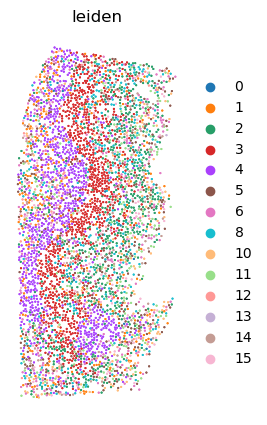

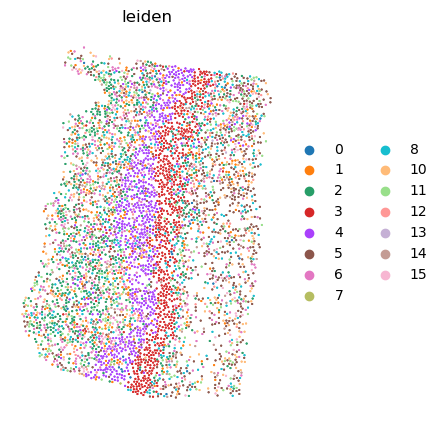

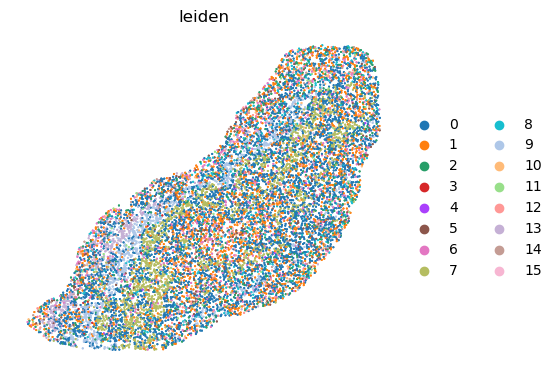

In [91]:
fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R1'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_1.png'), dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R2'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_2.png'), dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R3'], color="leiden", size=1, shape=None, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_21.png'), dpi=300)

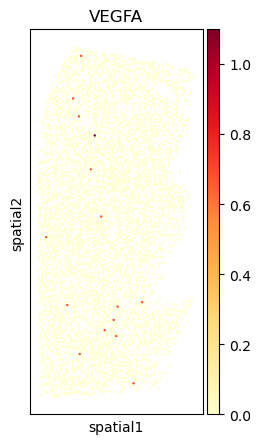

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R1'], color="VEGFA", size=1, cmap='YlOrRd', shape=None, ax=ax)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'OUTPUT_GENEPLOT_-_VEGFA.png'), dpi=300)

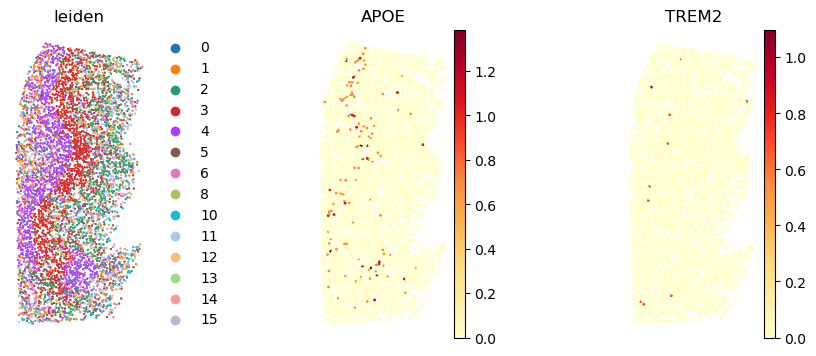

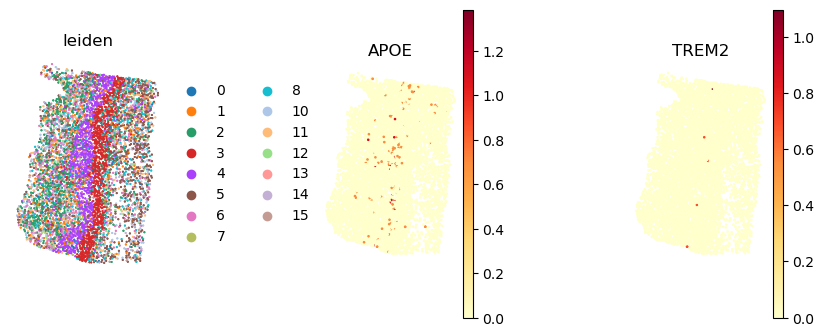

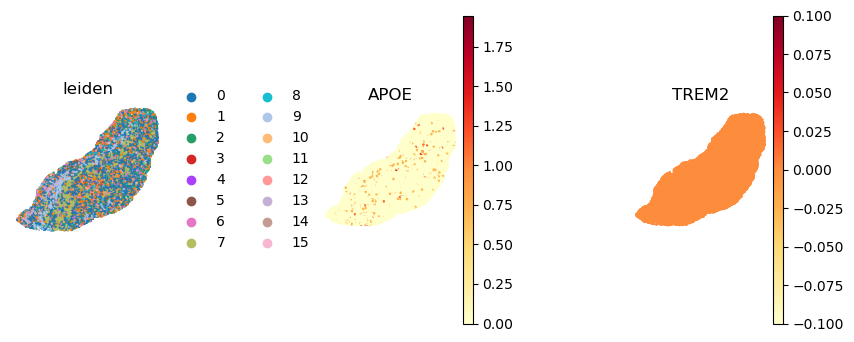

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 1}, figsize=(10,4))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R1'], color="leiden", size=1, shape=None, ax=ax[0])
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R1'], color="APOE", size=3, shape=None, cmap='YlOrRd', ax=ax[1])
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R1'], color="TREM2", size=3, shape=None, cmap='YlOrRd',ax=ax[2])
for axx in ax:
    axx.set_xlabel('')
    axx.set_ylabel('')
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    axx.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_1.png'), dpi=300)

fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 1}, figsize=(10,4))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R2'], color="leiden", size=1, shape=None, ax=ax[0])
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R2'], color="APOE", size=3, cmap='YlOrRd', shape=None, ax=ax[1])
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R2'], color="TREM2", size=3, cmap='YlOrRd', shape=None, ax=ax[2])
for axx in ax:
    axx.set_xlabel('')
    axx.set_ylabel('')
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    axx.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_2.png'), dpi=300)

fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 1}, figsize=(10,4))
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R3'], color="leiden", size=1, shape=None, ax=ax[0])
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R3'], color="APOE", size=3, cmap='YlOrRd', shape=None, ax=ax[1])
sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R3'], color="TREM2", size=3, cmap='YlOrRd', shape=None, ax=ax[2])
for axx in ax:
    axx.set_xlabel('')
    axx.set_ylabel('')
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    axx.spines['left'].set_visible(False)
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_Leiden_-_Retina_3.png'), dpi=300)

NameError: name 'SAVEFIGS' is not defined

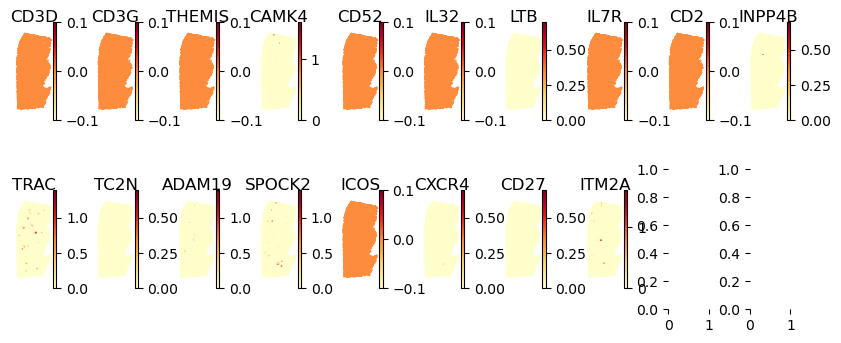

In [14]:
import json
import numpy as np


#import re
#gene_pattern = 'CD'
#gene_regex = re.compile(gene_pattern)
#matching_genes = [gene_name for gene_name in retinas_all.var_names if gene_regex.search(gene_name)]

with open(os.path.join(FILEPATHBASE,'02 Analysis/annData_ManualAnnotate/data/tcell_celltype_gates.json')) as f:                                                                                                                                                                                                                               
    gates = json.load(f)                                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                             
characteristic_genes = [g['gene'] for ct in gates for g in ct['gates']]       
matching_genes = [gene_name for gene_name in characteristic_genes if  gene_name in retinas_all.var_names]




fig, ax = plt.subplots(ncols=int(np.floor(len(matching_genes)/2))+1, nrows=2,  gridspec_kw={'wspace': 1}, figsize=(10,4))
ax = ax.reshape(-1)
a = 0
for gene in matching_genes:
    sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R1'],  color=gene, size=1, cmap='YlOrRd', shape=None, ax=ax[a])
    a=a+1
for axx in ax:
    axx.set_xlabel('')
    axx.set_ylabel('')
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    axx.spines['left'].set_visible(False)    
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_T-cell_markers_-_Retina_1.png'), dpi=300)



fig, ax = plt.subplots(ncols=int(np.floor(len(matching_genes)/2))+1, nrows=2,  gridspec_kw={'wspace': 1}, figsize=(10,4))
ax = ax.reshape(-1)
a = 0
for gene in matching_genes:
    sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R2'],  color=gene, size=1, cmap='YlOrRd', shape=None, ax=ax[a])
    a=a+1
for axx in ax:
    axx.set_xlabel('')
    axx.set_ylabel('')
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    axx.spines['left'].set_visible(False)    
if SAVEFIGS:
    fig.savefig(os.path.join(IMGDIR, 'Spatial_T-cell_markers_-_Retina_2.png'), dpi=300)



fig, ax = plt.subplots(ncols=int(np.floor(len(matching_genes)/2))+1, nrows=2,  gridspec_kw={'wspace': 1}, figsize=(10,4))
ax = ax.reshape(-1)
a = 0
for gene in matching_genes:
    sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']=='R3'],  color=gene, size=1, cmap='YlOrRd', shape=None, ax=ax[a])
    a=a+1
for axx in ax:
    axx.set_xlabel('')
    axx.set_ylabel('')
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    axx.spines['left'].set_visible(False)    
if SAVEFIGS:    
    fig.savefig(os.path.join(IMGDIR, 'Spatial_T-cell_markers_-_Retina_3.png'), dpi=300)

In [57]:
retinas_all.obs["T-cell score"] = np.array(np.sum(retinas_all[:,matching_genes].X > 0, axis=1) > 0, dtype=int)

In [102]:
import pandas as pd
import geopandas as gpd
import pysal.lib
import pysal.explore
import libpysal
from shapely.geometry import Point

spatial_coords = pd.DataFrame({
    'x': retinas_all.obsm['X_spatial'][:,0],
    'y': retinas_all.obsm['X_spatial'][:,1]
})

# Create a GeoDataFrame from the spatial coordinates DataFrame
geometry = gpd.points_from_xy(spatial_coords['x'], spatial_coords['y'])
gdf = gpd.GeoDataFrame(spatial_coords, geometry=geometry)

# Calculate spatial weights based on the spatial coordinates
w = libpysal.weights.Queen.from_dataframe(gdf)

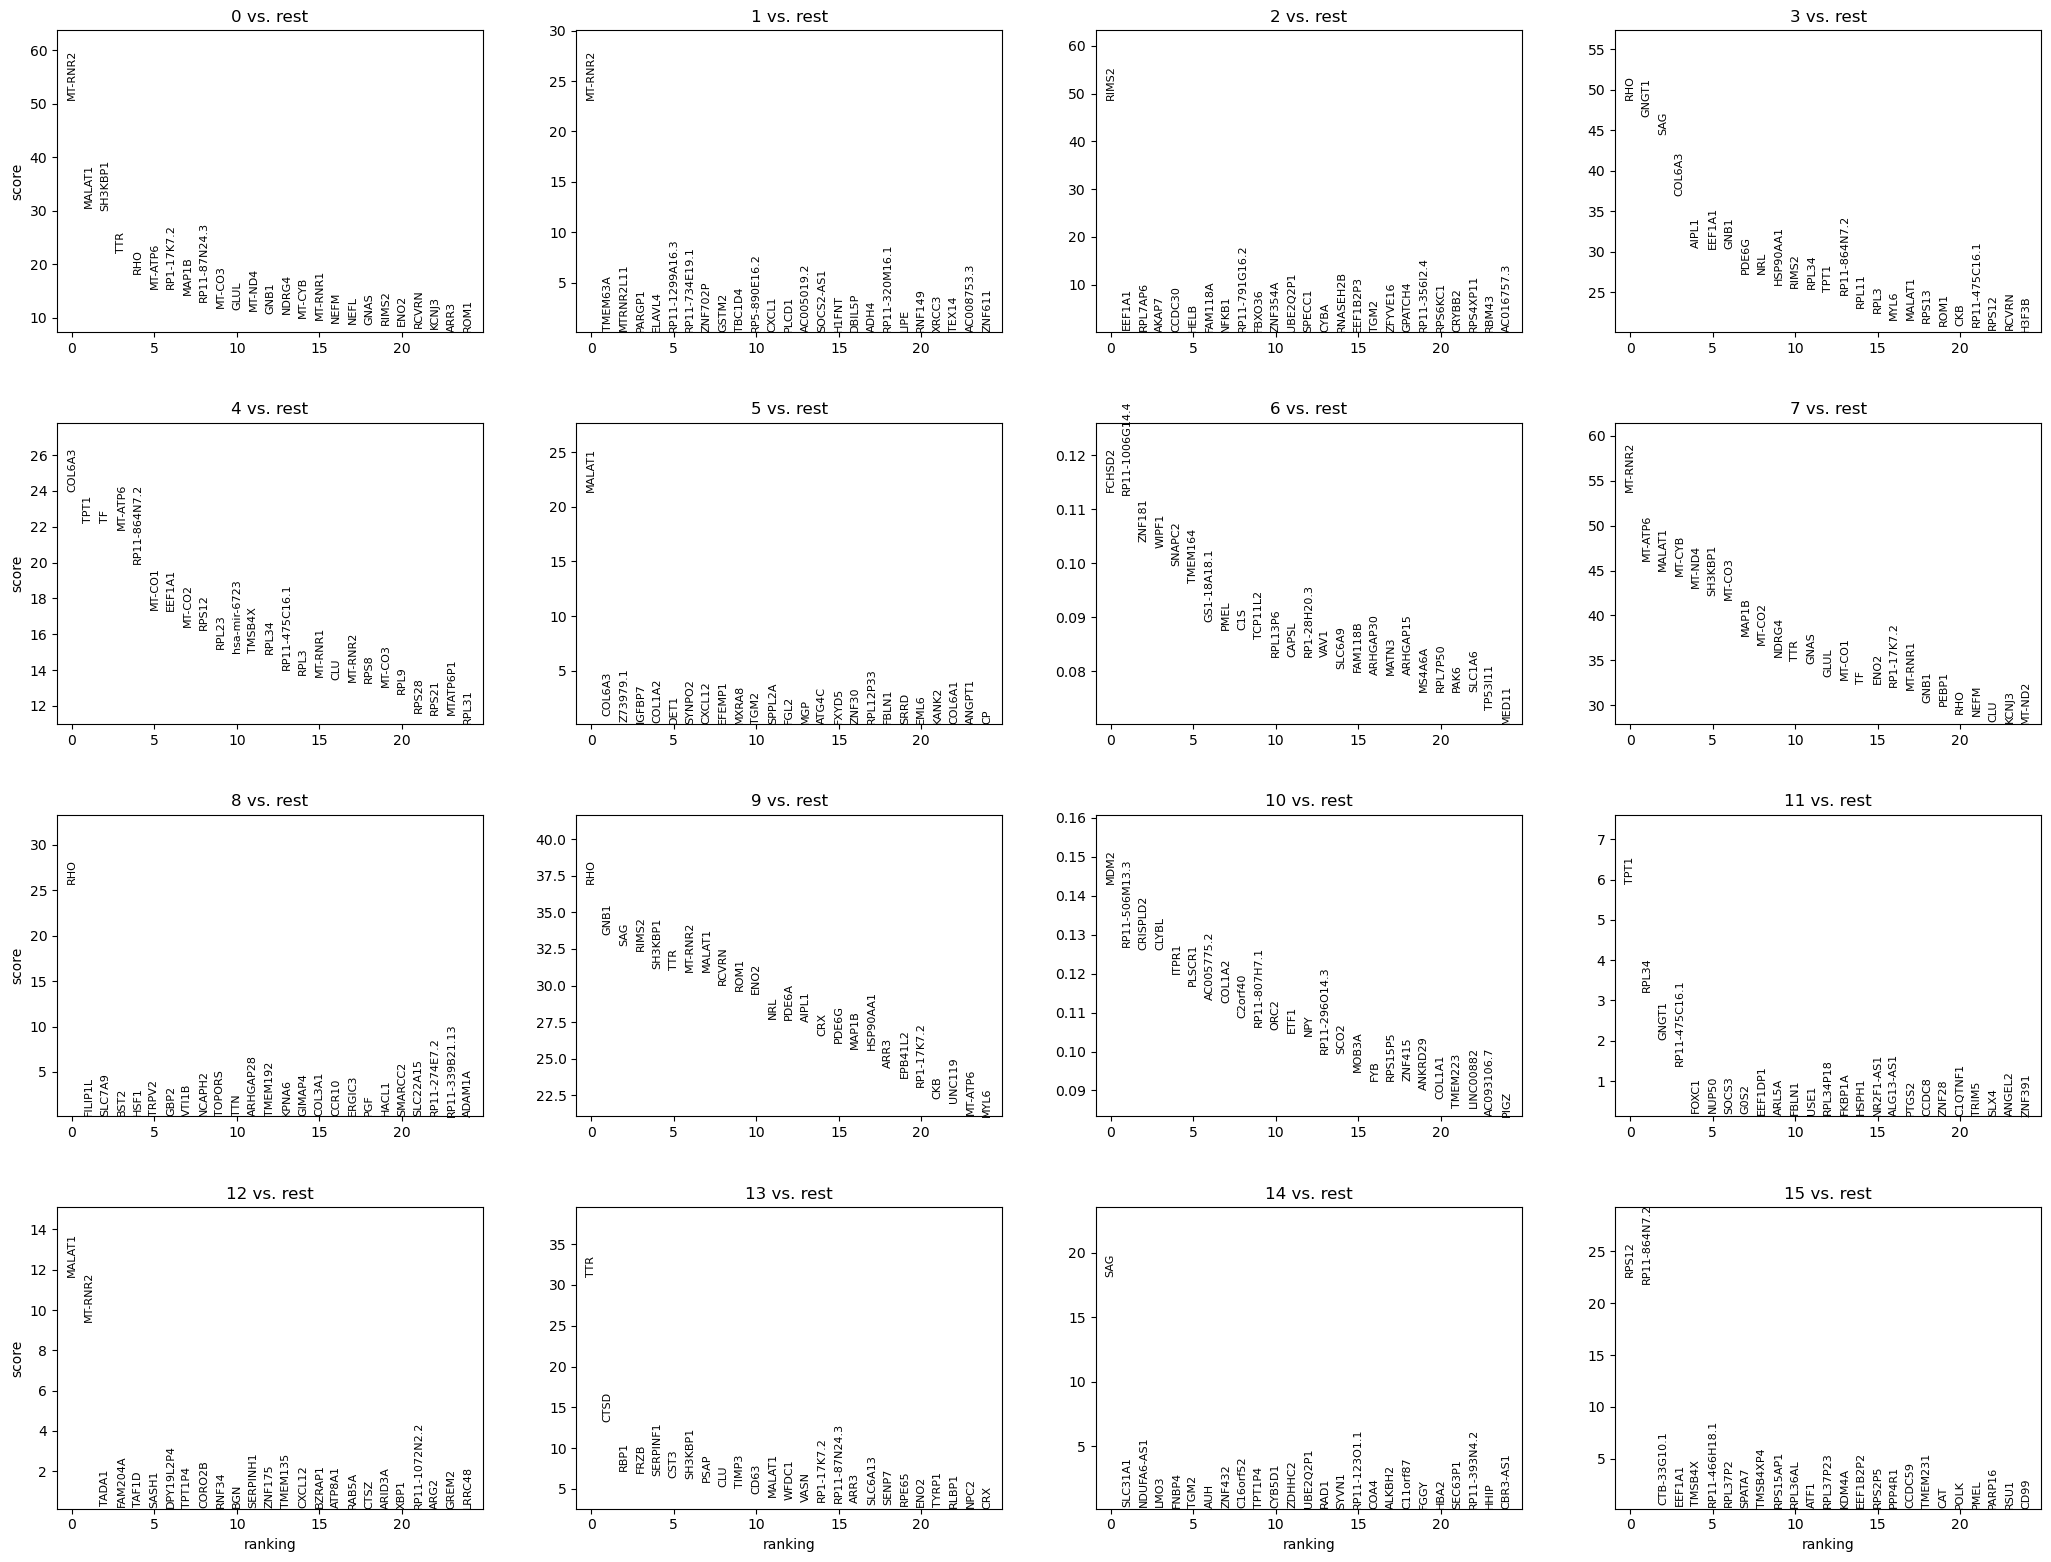

In [92]:
sc.tl.rank_genes_groups(retinas_all, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(retinas_all, n_genes=25, sharey=False)

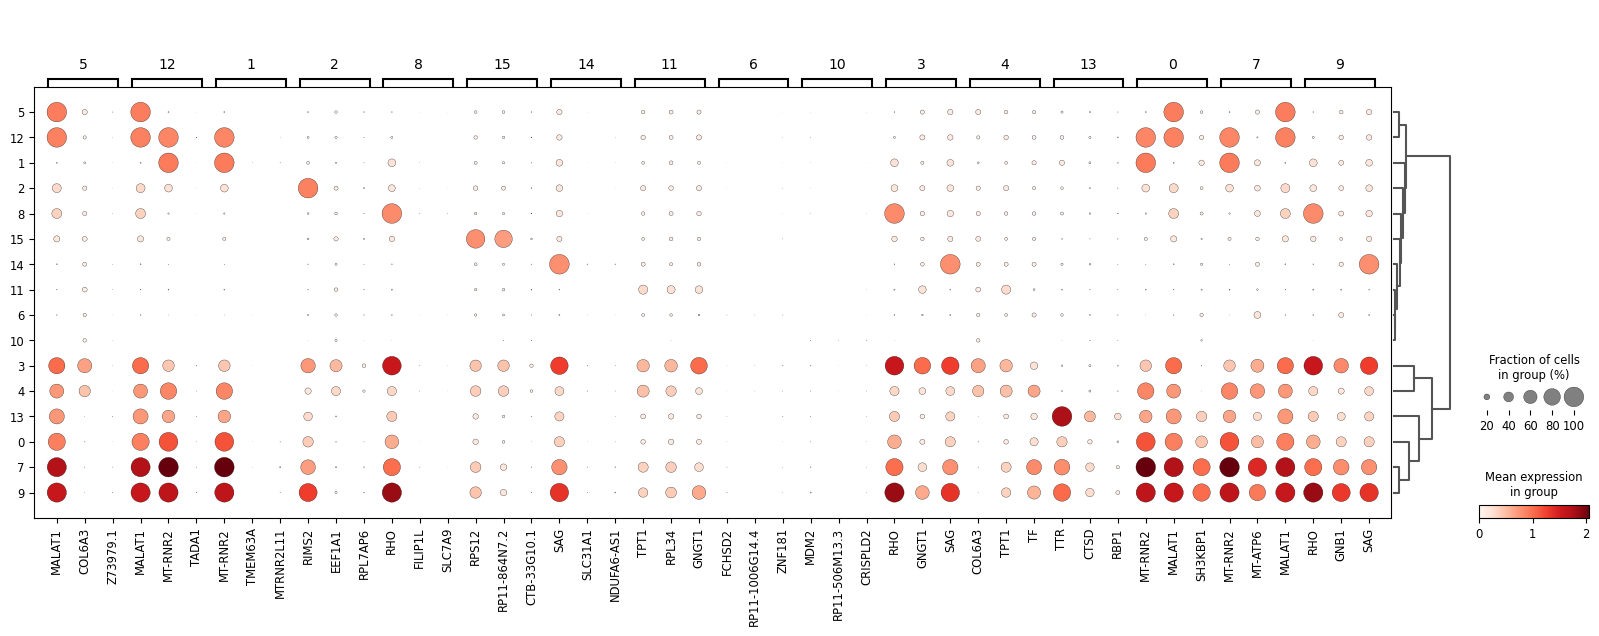

In [93]:
sc.pl.rank_genes_groups_dotplot(retinas_all, n_genes=3)

In [14]:


## Clustering
print('Clustering...')
sc.tl.pca(retina1, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(retina1, n_neighbors=20, n_pcs=30)
sc.tl.leiden(retina1)
sc.tl.paga(retina1)
sc.pl.paga(retina1, plot=False)
sc.tl.umap(retina1, init_pos='paga')

print('Done!')



## Clustering
print('Clustering...')
sc.tl.pca(retina2, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(retina2, n_neighbors=20, n_pcs=30)
sc.tl.leiden(retina2)
sc.tl.paga(retina2)
sc.pl.paga(retina2, plot=False)
sc.tl.umap(retina2, init_pos='paga')

print('Done!')



## Clustering
print('Clustering...')
sc.tl.pca(retina3, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(retina3, n_neighbors=20, n_pcs=30)
sc.tl.leiden(retina3)
sc.tl.paga(retina3)
sc.pl.paga(retina3, plot=False)
sc.tl.umap(retina3, init_pos='paga')

print('Done!')

Clustering...
Done!
Clustering...
Done!
Clustering...
Done!


In [ ]:
sc.tl.rank_genes_groups(retina1, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(retina1, n_genes=25, sharey=False)

In [ ]:

new_cluster_names = [
    'Photoreceptor (RHO, SAG, GNB1)', 
    'Photoreceptor (Cones); RIMS2',
    'Muller Glia', 
    'TF photorecptor',
    'Muller/RGC (MALAT-1)',
    'Photoreceptor (RHO)',
    'COL6A3/EEF1A1',
    'RGCs',
    '? RGC Progenitor (TPT1)',
    'Ribosomal protein L3',
    'Ribosomal proteins 1',
    'Ribosomal proteins 2',
    'Ribosomal proteins 3',
    'Other']
retina1.rename_categories('leiden', new_cluster_names)

sq.pl.spatial_scatter(retina1, color="leiden", size=1, shape=None)

In [ ]:
sq.pl.spatial_scatter(
    retina1,
    shape=None,
    color='leiden',
    groups=['RPE (MT-RNR2)','Photoreceptor (RHO, SAG, GNB1)',  'TF photorecptor', 'Outer plexiform'],
    size=3,
)


In [ ]:
sc.tl.rank_genes_groups(retina2, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(retina2, n_genes=25, sharey=False)

In [ ]:
fig = sq.pl.spatial_scatter(retina2, color="leiden", size=1, shape=None, return_fig=True)
fig.savefig(os.path.join(IMGDIR,'Retina2.png'), dpi=300)

In [ ]:
sc.tl.rank_genes_groups(retina3, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(retina3, n_genes=25, sharey=False)

In [ ]:
sq.pl.spatial_scatter(retina3, color="leiden", size=1, shape=None)